**Necessary imports**

In [3]:
import os
import wrds
import pandas as pd
import warnings
import numpy as np
from functools import reduce
warnings.filterwarnings("ignore")

**STEP 1 : data collection from wrds**

In [ ]:
user_name = os.getenv('WRDS_USERNAME')
db = wrds.Connection(wrds_username=user_name)

In [1427]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='2002-03-01'
            and mcaldt<='2024-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100


Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

Rf.set_index('date', inplace = True)

#Get the crsp value-weighted return index
query_crsp = """select  date,vwretd from crsp.msi 
                where date>='2002-03-01' and date<='2024-12-31'"""

crsp_returns = db.raw_sql(query_crsp,  date_cols=['date'])
crsp_returns = crsp_returns.rename(columns={'vwretd': 'us_return'})
crsp_returns.to_csv('data/crsp_return.csv')
Rf.to_csv('data/t_bills_one_month.csv')

KeyboardInterrupt: 

In [4]:
crsp_returns = pd.read_csv('data/crsp_return.csv')
crsp_returns = crsp_returns.drop(columns= 'Unnamed: 0')#D'ou ca vient ???
crsp_returns['date'] = pd.to_datetime(crsp_returns['date'])
crsp_returns['date'] = crsp_returns['date'].dt.to_period('M').dt.to_timestamp('M') 

In [8]:
#Interest Rates: 3-Month or 90-Day Rates and Yields: Interbank Rates
def load_and_prepare_ir3(filepath, rename_dict):
    df = pd.read_csv(filepath).rename(columns=rename_dict)
    df['date'] = pd.to_datetime(df['date'])    
    df['date'] = df['date'].dt.to_period('M').dt.to_timestamp('M') 
    df[df.columns[1]] /= 100
    return df.set_index('date')                 

# Load each series using the helper
ir3_japan = load_and_prepare_ir3("data/IR3TIB01JPM156N.csv", {"observation_date": "date", "IR3TIB01JPM156N": "ir3_jpn"})
ir3_fra   = load_and_prepare_ir3("data/IR3TIB01FRM156N.csv", {"observation_date": "date", "IR3TIB01FRM156N": "ir3_fra"})
ir3_gb    = load_and_prepare_ir3("data/IR3TIB01GBM156N.csv", {"observation_date": "date", "IR3TIB01GBM156N": "ir3_gb"})
ir3_us    = load_and_prepare_ir3("data/IR3TIB01USM156N.csv", {"observation_date": "date", "IR3TIB01USM156N": "ir3_us"})
ir3_aus   = load_and_prepare_ir3("data/IR3TIB01AUM156N.csv", {"observation_date": "date", "IR3TIB01AUM156N": "ir3_aus"})
ir3_ch    = load_and_prepare_ir3("data/IR3TIB01CHM156N.csv", {"observation_date": "date", "IR3TIB01CHM156N": "ir3_ch"})
ir3_deu   = load_and_prepare_ir3("data/IR3TIB01DEM156N.csv", {"observation_date": "date", "IR3TIB01DEM156N": "ir3_deu"})



# JPY: DEXJPUS (JPY per 1 USD) 
df_jpy = pd.read_csv("data/EXJPUS.csv").rename(columns={"observation_date": "date"})

df_jpy.name = "JPY_per_USD"

# CHF: DEXSZUS (CHF per 1 USD)
df_chf = pd.read_csv("data/EXSZUS.csv").rename(columns={"observation_date": "date"})
df_chf.name = "CHF_per_USD"

# AUD: DEXUSAL (USD per 1 AUD) 
df_aud = pd.read_csv("data/EXUSAL.csv").rename(columns={"observation_date": "date"})
df_aud["AUD_per_USD"] = 1 / df_aud["EXUSAL"]


# EUR: DEXUSEU (USD per 1 EUR) 
df_eur = pd.read_csv("data/EXUSEU.csv").rename(columns={"observation_date": "date"})
df_eur["EUR_per_USD"] = 1 / df_eur["EXUSEU"]

# GBP: DEXUSUK (USD per 1 GBP) 
df_gbp = pd.read_csv("data/EXUSUK.csv").rename(columns={"observation_date": "date"})
df_gbp["GBP_per_USD"] = 1 / df_gbp["EXUSUK"]

files = {
    'jpn': 'data/jpn.csv',
    'aus': 'data/aus.csv',
    'deu': 'data/deu.csv',
    'fra': 'data/fra.csv',
    'ch':  'data/swz.csv',
    'gb':  'data/uk.csv'
}

country_data = {}

for code, path in files.items():
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.to_period('M').dt.to_timestamp('M') 
 
    return_col = [col for col in df.columns if col != 'date'][0]
    df = df.rename(columns={return_col: f'{code}_return'})
    country_data[code] = df



In [9]:
foreign_to_usd = pd.concat([
    df_jpy['EXJPUS'].rename("JPY_per_USD"),
    df_chf['EXSZUS'].rename("CHF_per_USD"),
    df_aud['AUD_per_USD'].rename("AUD_per_USD"),
    df_eur['EUR_per_USD'].rename("EUR_per_USD"),
    df_gbp['GBP_per_USD'].rename("GBP_per_USD")
], axis=1)
foreign_to_usd.index = pd.to_datetime(df_jpy['date']).dt.to_period('M').dt.to_timestamp('M') 

**Visualizing the data**

<Figure size 800x400 with 0 Axes>

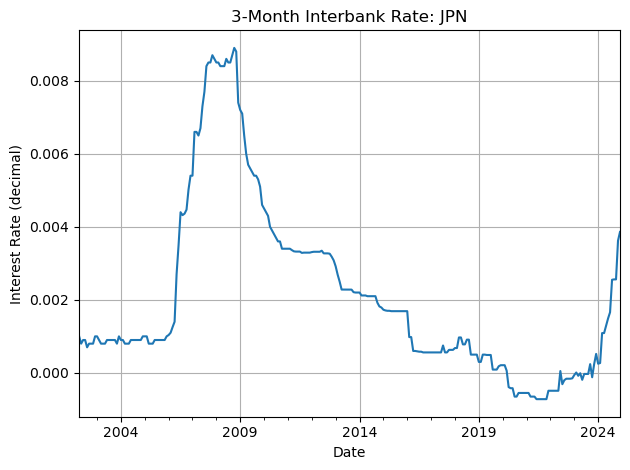

<Figure size 800x400 with 0 Axes>

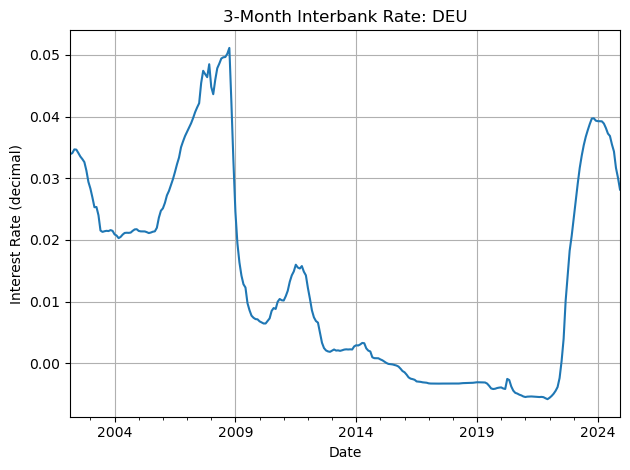

<Figure size 800x400 with 0 Axes>

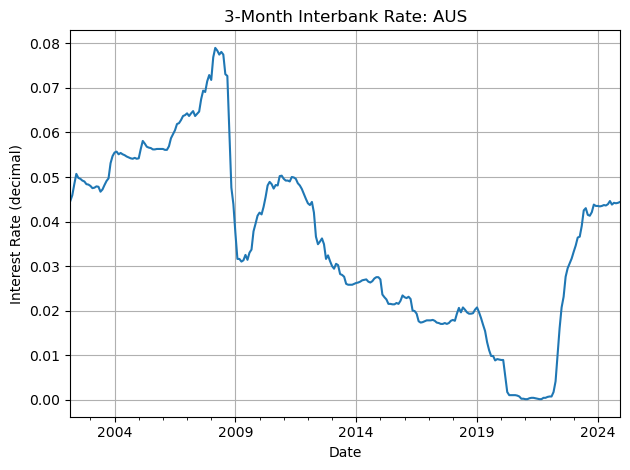

<Figure size 800x400 with 0 Axes>

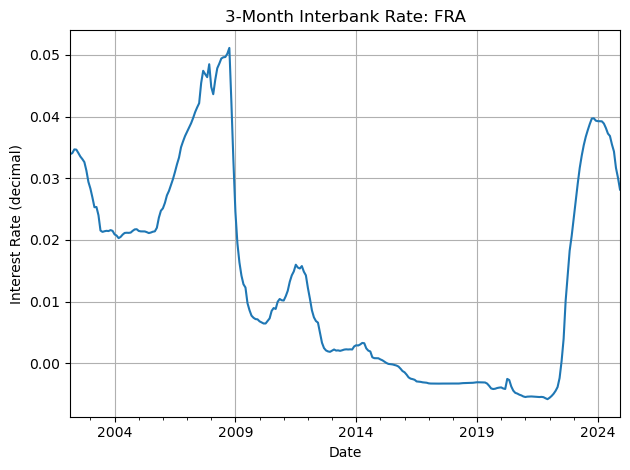

<Figure size 800x400 with 0 Axes>

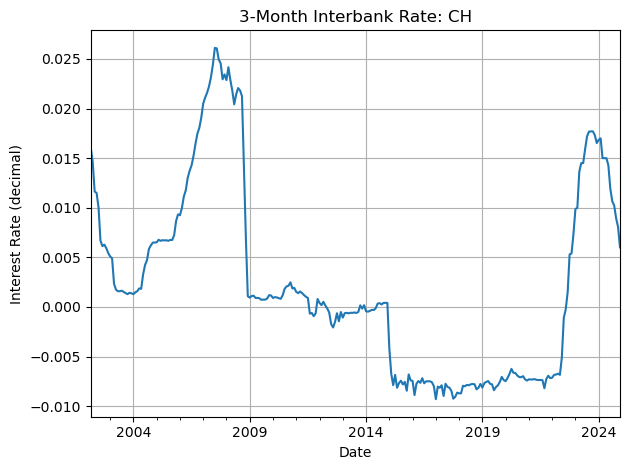

<Figure size 800x400 with 0 Axes>

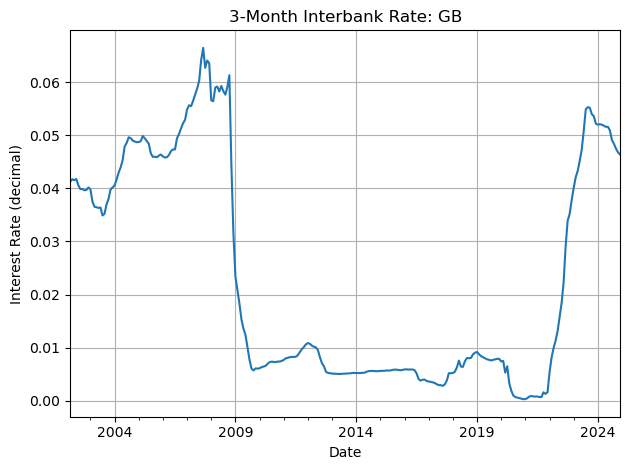

<Figure size 800x400 with 0 Axes>

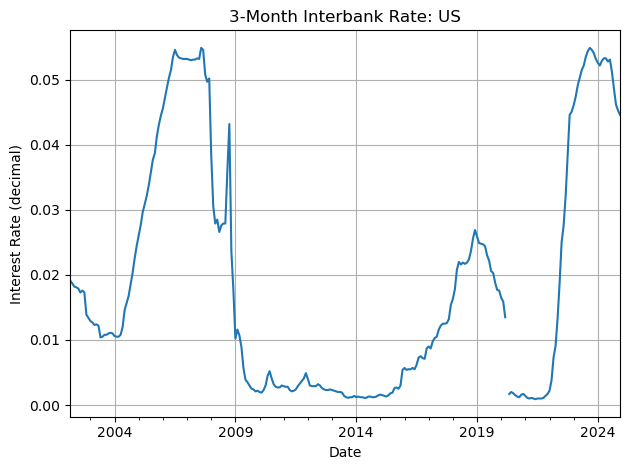

In [10]:
import matplotlib.pyplot as plt
ir3_data = {
    'jpn': ir3_japan,
    'deu': ir3_deu,
    'aus': ir3_aus,
    'fra': ir3_fra,
    'ch': ir3_ch,
    'gb': ir3_gb,
    'us' : ir3_us
}

for country, df in ir3_data.items():
    plt.figure(figsize=(8, 4))
    df.plot(y=f'ir3_{country}', legend=False)
    plt.title(f'3-Month Interbank Rate: {country.upper()}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate (decimal)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**We observe a missing value in 2020 for the us interbank rate, to replace it we will use interpolation**

In [11]:
ir3_data['us'] = ir3_us.interpolate(method='time')

<Axes: xlabel='date'>

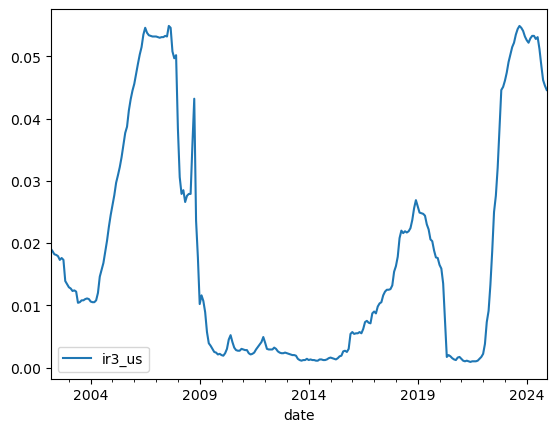

In [12]:
ir3_data['us'].plot()

**Now it is interpolated, and all our data is continuous ! **

In [13]:
#Merge all the interbank together 
ir3_all = pd.concat(
    [df.rename(columns={df.columns[0]: f'ir3_{code}'}) for code, df in ir3_data.items()],
    axis=1,
    join='outer'
)


**Let's plot the exchange rate**

<Figure size 1000x400 with 0 Axes>

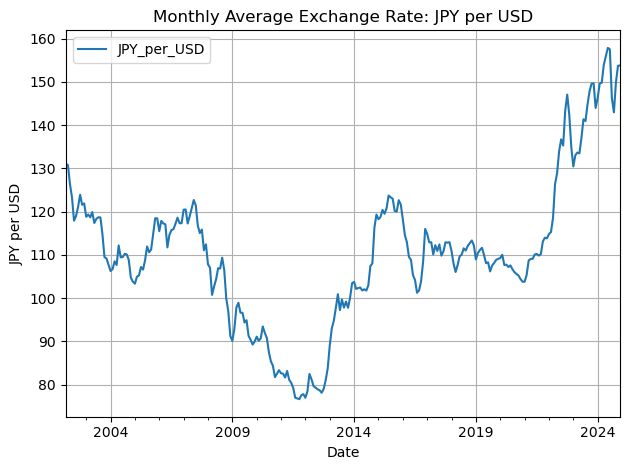

<Figure size 1200x600 with 0 Axes>

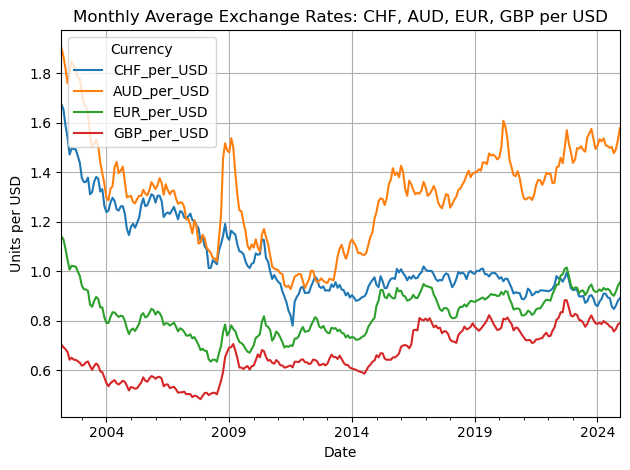

In [14]:
# Separate JPY from others
monthly_jpy = foreign_to_usd[['JPY_per_USD']]
monthly_others = foreign_to_usd.drop(columns='JPY_per_USD')


plt.figure(figsize=(10, 4))
monthly_jpy.plot()
plt.title("Monthly Average Exchange Rate: JPY per USD")
plt.xlabel("Date")
plt.ylabel("JPY per USD")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
monthly_others.plot()
plt.title("Monthly Average Exchange Rates: CHF, AUD, EUR, GBP per USD")
plt.xlabel("Date")
plt.ylabel("Units per USD")
plt.grid(True)
plt.legend(title="Currency", loc="upper left")
plt.tight_layout()
plt.show()

### Foreign Index Return in USD

The formula to convert a foreign index return to USD is:

$$
R_{DC} = (1 + R_{FC}) \cdot (1 + R_{FX}) - 1
$$

Where:

- \( R_{DC} \): Return in domestic currency (USD)  
- \( R_{FC} \): Return in foreign currency  
- \( R_{FX} \): Return on the exchange rate (foreign per USD)


Returns can be expressed as $\log{\frac{R_{t}}{R_t - 1}}$

In [15]:
def convert_foreign_to_usd(ret_foreign_currency, ret_fx):
    return (1 + ret_foreign_currency) * (1 + ret_fx) - 1

# Step 1: Compute FX returns
ret_exchange_rate = foreign_to_usd / foreign_to_usd.shift(1) - 1 
ret_exchange_rate.dropna(inplace=True)
ret_exchange_rate.sort_index(inplace=True)


def process_country(df, fx_column, ret_exchange_rate):
    df = df[['date', 'country', 'mportret']].copy()
    df.dropna(subset=['mportret'], inplace=True)

    # Merge on date to align
    df = df.merge(ret_exchange_rate[[fx_column]], how='inner', left_on='date', right_index=True)

    # Convert to USD returns
    df['mportret'] = convert_foreign_to_usd(df['mportret'], df[fx_column])
    df = df[['date', 'country', 'mportret']]
    return df


jpn = process_country(country_data['jpn'], 'JPY_per_USD', ret_exchange_rate)
aus = process_country(country_data['aus'], 'AUD_per_USD', ret_exchange_rate)
deu = process_country(country_data['deu'], 'EUR_per_USD', ret_exchange_rate)
fra = process_country(country_data['fra'], 'EUR_per_USD', ret_exchange_rate)
ch  = process_country(country_data['ch'],  'CHF_per_USD', ret_exchange_rate)
gb  = process_country(country_data['gb'],  'GBP_per_USD', ret_exchange_rate)


crsp_returns['country'] = 'US'
crsp_returns.rename(columns={'us_return': 'mportret'}, inplace=True)
us = crsp_returns[['date', 'country', 'mportret']].copy()
us = us.dropna().iloc[1:-1]  # Drop first and last row

# Combine all
merged_all = pd.concat([jpn, aus, deu, fra, ch, gb, us], axis=0, ignore_index=True)


In [16]:
merged_all['date'] = pd.to_datetime(merged_all['date'])
merged_all['date'] = merged_all['date'].dt.to_period('M').dt.to_timestamp('M')

**PROBLEM WITH AUStralia We neED to find what. The following is to see why** 

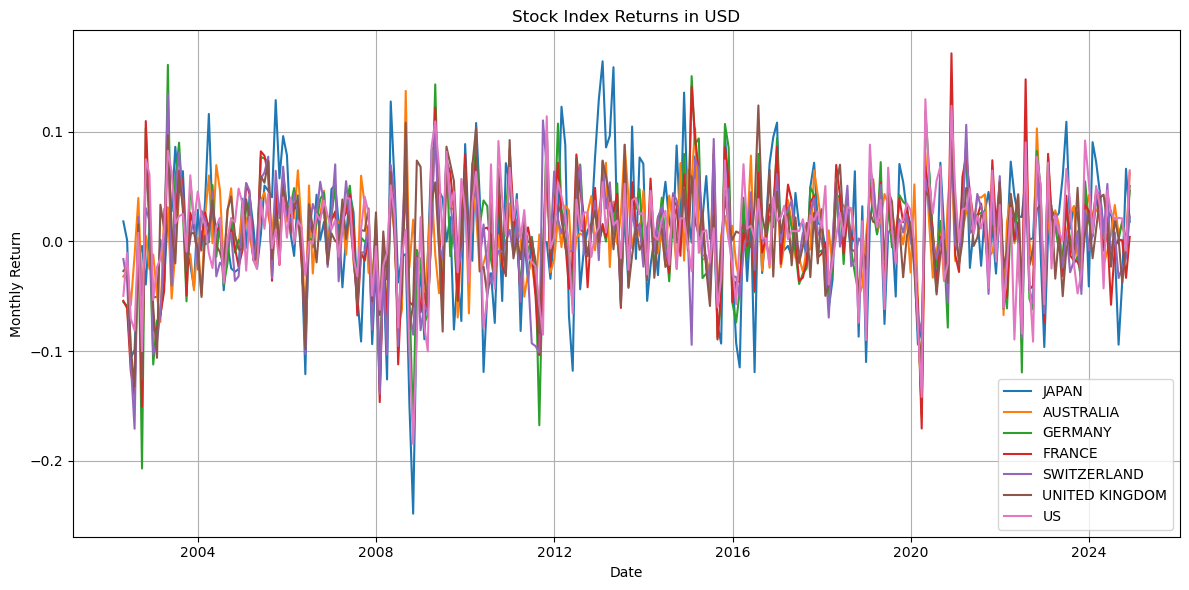

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for country in merged_all['country'].unique():
    subset = merged_all[merged_all['country'] == country]
    plt.plot(subset['date'], subset['mportret'], label=country)

plt.title('Stock Index Returns in USD')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import matplotlib.pyplot as plt

def compare_countries(merged_all, country1, country2, return_type='mportret'):
    """
    Plot cumulative returns in USD of two countries from the merged_all dataframe.
    
    Parameters:
        merged_all (DataFrame): Combined dataset with 'date', 'country', and return columns.
        country1, country2 (str): Country names to compare (must match 'country' column values).
        return_type (str): Either 'mportret' (unhedged) or 'mportretx' (hedged).
    """
    df1 = merged_all[merged_all['country'] == country1][['date', return_type]].copy()
    df2 = merged_all[merged_all['country'] == country2][['date', return_type]].copy()

    # Merge on date to ensure strict alignment
    df = df1.merge(df2, on='date', suffixes=(f'_{country1}', f'_{country2}'))

    # Compute cumulative returns
    df[f'cumulative_{country1}'] = (1 + df[f'{return_type}_{country1}']).cumprod()
    df[f'cumulative_{country2}'] = (1 + df[f'{return_type}_{country2}']).cumprod()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df[f'cumulative_{country1}'], label=country1, linewidth=2)
    plt.plot(df['date'], df[f'cumulative_{country2}'], label=country2, linewidth=2)
    plt.title(f'Cumulative Return in USD: {country1} vs {country2}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Start = 1)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


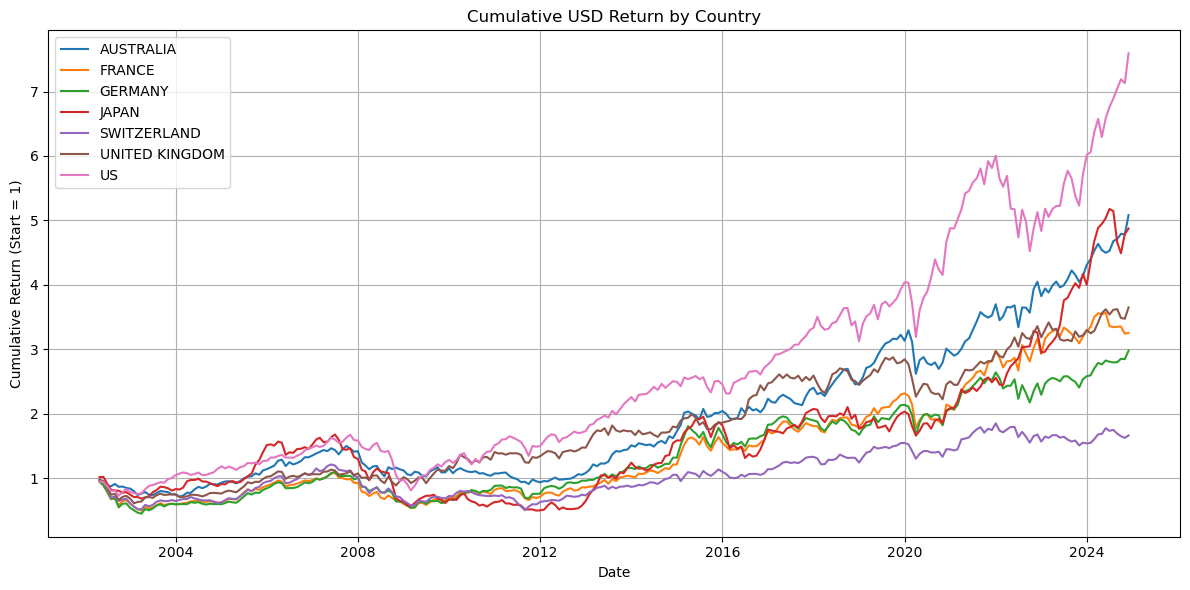

In [19]:
merged_all_filtered = merged_all[merged_all['date'] > '2002-01-01']

plt.figure(figsize=(12, 6))

# Plot cumulative returns for each country
for country, group in merged_all_filtered.groupby('country'):
    cumulative = (1 + group['mportret']).cumprod()
    plt.plot(group['date'], cumulative, label=country)

plt.title('Cumulative USD Return by Country')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Start = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Currency-Hedged Excess Return in USD

The formula for the **excess return** in USD from a $1 investment in the Euro-currency hedged via shorting the foreign currency is:

$$
X_{t+1}^{\text{EU}} = \frac{S_{t+1}}{S_t}(1 + r^{\text{EU}}) - (1 + r^{\text{US}})
$$

Where:

- \( X_{t+1}^{\text{EU}} \): Excess return in USD from the currency-hedged investment in the Euro-currency  
- \( S_t \): Spot exchange rate at time \( t \), in USD per EUR  
- \( S_{t+1} \): Spot exchange rate at time \( t+1 \), in USD per EUR  
- \( r^{\text{EU}} \): Risk-free interest rate in the Eurozone over the period  
- \( r^{\text{US}} \): Risk-free interest rate in the US over the period  


Get USD per euro 

In [20]:

usd_to_foreign = 1 / foreign_to_usd
usd_to_foreign.columns = [f'USD_PER_{col.split("_")[0]}' for col in usd_to_foreign.columns]


proportion = usd_to_foreign.shift(-1) / usd_to_foreign
proportion = proportion.dropna()


ir3_filtered = ir3_all.iloc[:-1]  


excess_return = pd.DataFrame({
    'JAPAN': proportion['USD_PER_JPY'] * (1 + ir3_filtered['ir3_jpn']) - (1 + ir3_filtered['ir3_us']),
    'FRANCE': proportion['USD_PER_EUR'] * (1 + ir3_filtered['ir3_fra']) - (1 + ir3_filtered['ir3_us']),
    'GERMANY': proportion['USD_PER_EUR'] * (1 + ir3_filtered['ir3_deu']) - (1 + ir3_filtered['ir3_us']),
    'AUSTRALIA': proportion['USD_PER_AUD'] * (1 + ir3_filtered['ir3_aus']) - (1 + ir3_filtered['ir3_us']),
    'SWITZERLAND': proportion['USD_PER_CHF'] * (1 + ir3_filtered['ir3_ch']) - (1 + ir3_filtered['ir3_us']),
    'UNITED KINGDOM': proportion['USD_PER_GBP'] * (1 + ir3_filtered['ir3_gb']) - (1 + ir3_filtered['ir3_us'])
})
excess_return = excess_return.iloc[2:]  # if needed based on further alignment


hedge_return = pd.DataFrame()
countries = ['JAPAN', 'FRANCE', 'GERMANY', 'AUSTRALIA', 'SWITZERLAND', 'UNITED KINGDOM']

for c in countries:
    df = merged_all[merged_all['country'] == c].copy()
    df = df.set_index('date')  


    excess = excess_return[c]

    # Align both on index intersection
    aligned_df, aligned_excess = df.align(excess, join='inner', axis=0)

    hedge_return[c] = aligned_df['mportret'] - aligned_excess


In [21]:
aligned_strategy = ir3_all.loc[ir3_all.index >= '2002-04-01']
rows_with_nans = aligned_strategy[aligned_strategy.isna().any(axis=1)]
print(rows_with_nans)


Empty DataFrame
Columns: [ir3_jpn, ir3_deu, ir3_aus, ir3_fra, ir3_ch, ir3_gb, ir3_us]
Index: []


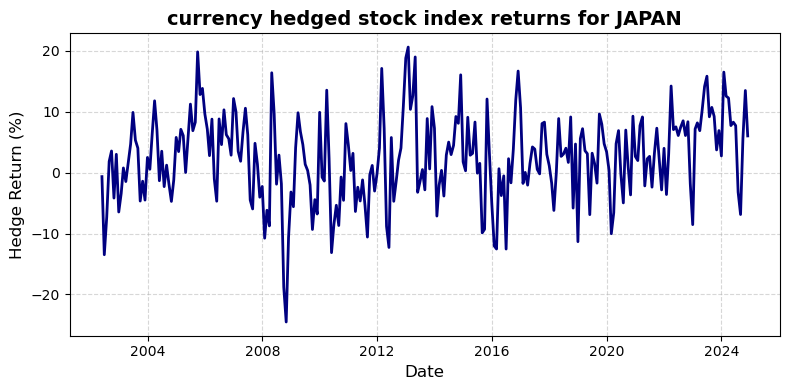

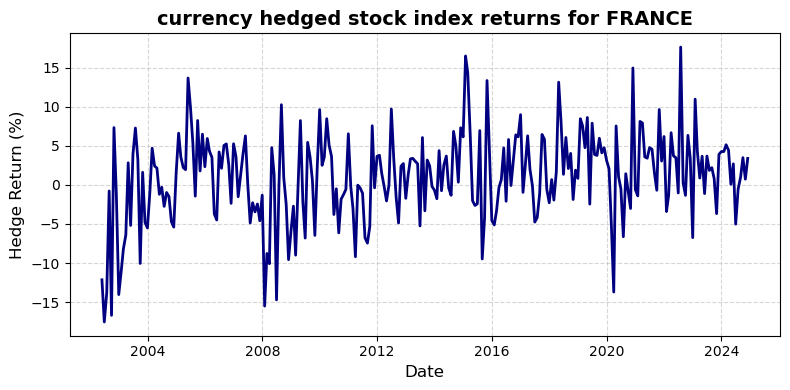

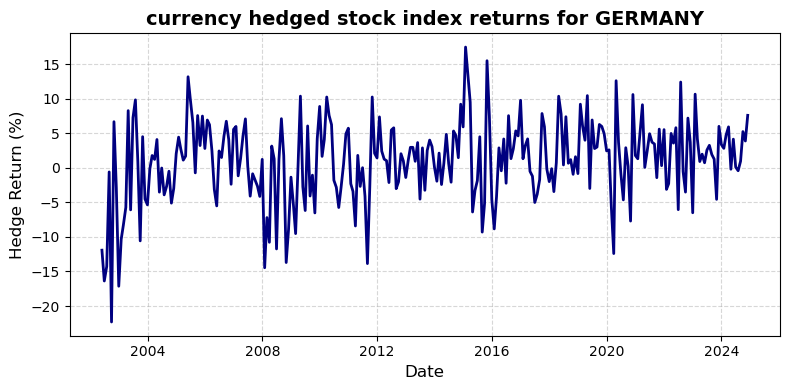

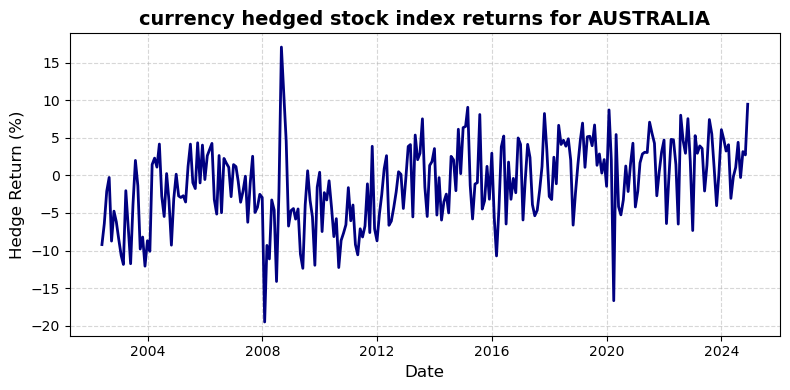

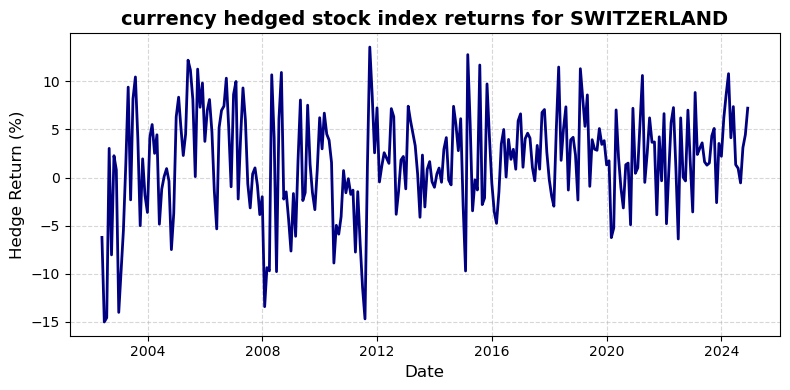

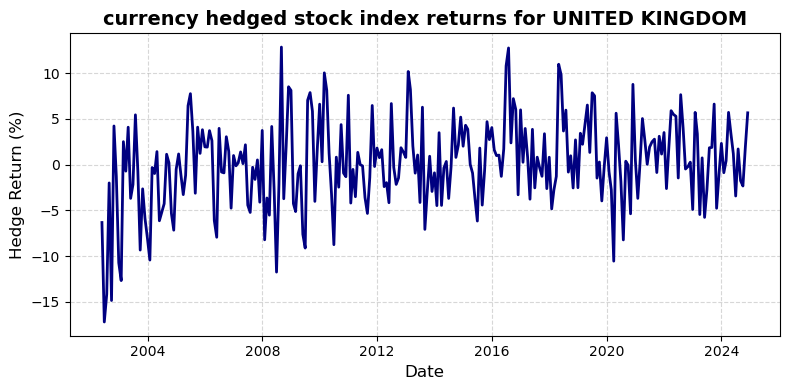

In [22]:
for country in hedge_return.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(hedge_return[country] * 100, color='navy', linewidth=2)
    plt.title(f'currency hedged stock index returns for {country.upper()}', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Hedge Return (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

**C** •Equal weight the indexes No currency hedging

In [23]:
def evaluate_strategy_performance(strategy_return: pd.Series, Rf: pd.Series, name: str = "Strategy"):
    """
    Evaluate the performance of a strategy vs. the risk-free rate.
    
    Parameters:
    - strategy_return: pd.Series of monthly strategy returns (e.g., equal-weighted)
    - Rf: pd.Series of monthly risk-free rate (same units)
    - name: Optional name to use in the output

    Returns:
    - Dictionary with mean, std, Sharpe ratio
    """
    

    # Align both series
    common_dates = strategy_return.index.intersection(Rf.index)

    aligned_strategy = strategy_return.loc[common_dates]
    aligned_rf = Rf.loc[common_dates]
 
    # Compute excess returns
    excess_return = aligned_strategy.values - aligned_rf.values
    mean_excess = excess_return.mean()
    std_excess = excess_return.std()
    sharpe_annualized = (mean_excess / std_excess) * np.sqrt(12)

    print("-" * 50)
    print(f"Performance Summary for: {name}")
    print(f"Mean Monthly Excess Return   : {mean_excess:.5f}")
    print(f"Standard Deviation (Monthly) : {std_excess:.5f}")
    print(f"Annualized Sharpe Ratio      : {sharpe_annualized:.3f}")
    print("-" * 50)

In [24]:
pivoted = merged_all.pivot(index='date', columns='country', values='mportret')

equal_weight = pivoted.mean(axis=1)

In [95]:
evaluate_strategy_performance(equal_weight, Rf, name="Equal Weight Strategy")


--------------------------------------------------
Performance Summary for: Equal Weight Strategy
Mean Monthly Excess Return   : 0.00480
Standard Deviation (Monthly) : 0.03882
Annualized Sharpe Ratio      : 0.428
--------------------------------------------------


**C** •Equal weight the indexes currency hedging

In [1406]:
equal_weight_hedged = hedge_return.mean(axis=1)
evaluate_strategy_performance(equal_weight_hedged, Rf,name = "Equal Weight Hedged Return Strategy")

--------------------------------------------------
Performance Summary for: Equal Weight Hedged Return Strategy
Mean Monthly Excess Return   : 0.00702
Standard Deviation (Monthly) : 0.04589
Annualized Sharpe Ratio      : 0.530
--------------------------------------------------


**C** •Risk-Parity based on a 60 months rolling window estimate of the strategy returns
volatilities

In [102]:
Rf = pd.read_csv('data/t_bills_one_month.csv')
Rf['date'] = pd.to_datetime(Rf['date'])
Rf['date'] = Rf['date'].dt.to_period('M').dt.to_timestamp('M') 
Rf.set_index('date', inplace=True)

In [ ]:
windowed_std = pivoted.rolling(window=60).std()
windowed_std.dropna(inplace=True)

rp_weights = 1/windowed_std

rp_weights_normalized = rp_weights.div(rp_weights.sum(axis=1), axis=0)


common_dates = pivoted.index.intersection(rp_weights_normalized.index)
aligned_extend_pivoted = pivoted.loc[common_dates]


value_portfolio = aligned_extend_pivoted*rp_weights_normalized

In [104]:
portfolio_returns = value_portfolio.sum(axis=1)

evaluate_strategy_performance(portfolio_returns,  Rf,name='Risk parity strategy')

--------------------------------------------------
Performance Summary for: Risk parity strategy
Mean Monthly Excess Return   : 0.00546
Standard Deviation (Monthly) : 0.03715
Annualized Sharpe Ratio      : 0.509
--------------------------------------------------


**C** •Risk-Parity based on a 60 months rolling window estimate of the strategy returns
volatilities with currency hedge

In [105]:
windowed_std_hedge = hedge_return.rolling(window=60).std()
windowed_std_hedge.dropna(inplace=True)


rp_weights_hedge = 1 / windowed_std_hedge


rp_weights_hedge_normalized = rp_weights_hedge.div(rp_weights_hedge.sum(axis=1), axis=0)


common_dates_hedge = hedge_return.index.intersection(rp_weights_hedge_normalized.index)
aligned_extended_pivoted_hedge = hedge_return.loc[common_dates_hedge]

value_portfolio_hedge = aligned_extended_pivoted_hedge * rp_weights_hedge_normalized


In [106]:
portfolio_returns_hedge = value_portfolio_hedge .sum(axis=1)

evaluate_strategy_performance(portfolio_returns_hedge,  Rf,name='Risk parity strategy with currency hedge')

--------------------------------------------------
Performance Summary for: Risk parity strategy with currency hedge
Mean Monthly Excess Return   : 0.00935
Standard Deviation (Monthly) : 0.04178
Annualized Sharpe Ratio      : 0.775
--------------------------------------------------


**C** •Mean-variance optimal combination based on the rolling window mean and co-
variance matrix

In [135]:

mean_windowed = pivoted.rolling(window=60).mean()
cov_windowed  = pivoted.rolling(window=60).cov()

mean_windowed.dropna(inplace=True)
cov_windowed.dropna(inplace=True)

inv_cov_series = (
    cov_windowed
    .groupby(level=0)
    .apply(lambda mat: pd.DataFrame(
        np.linalg.pinv(mat.droplevel(0).values),  
        index=mat.index.get_level_values(1).unique(),  
        columns=mat.columns  
    ))
)

In [154]:
common_dates = mean_windowed.index.intersection(Rf.index)
aligned_strategy = mean_windowed.loc[common_dates]
aligned_rf = Rf.loc[common_dates]

aligned_rf = aligned_rf.squeeze()
excess_mean = mean_windowed.sub(aligned_rf, axis=0)

In [161]:
def compute_tangency_weights(mu, inv_cov ) :
    tangency = inv_cov @ mu
    risk_aversion = tangency.sum()
    return tangency / risk_aversion

tangency_weights = pd.DataFrame({
    date: compute_tangency_weights(excess_mean.loc[date], inv_cov_series.loc[date])
    for date in excess_mean.index
}).T

tangency_weights.index = excess_mean.index
tangency_weights.columns = excess_mean.columns

In [166]:
tangency_portfolio = aligned_extend_pivoted*tangency_weights


tangency_returns = tangency_portfolio.sum(axis = 1)

In [169]:
evaluate_strategy_performance(tangency_returns, aligned_rf,name = 'Tangency strategy')

--------------------------------------------------
Performance Summary for: Tangency strategy
Mean Monthly Excess Return   : 0.82196
Standard Deviation (Monthly) : 15.04935
Annualized Sharpe Ratio      : 0.189
--------------------------------------------------
